<a href="https://colab.research.google.com/github/Gakwaya011/summative_intro_to_ml/blob/main/Summative_Intro_to_ml_%5Bname_number%5D_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [17]:
#Import Necessary Libraries

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2 # For L2 regularization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os # For saving/loading models


## Case Study and Implementation

### The Dataset
#### Brief Description:
**State the Problem:**
Rapid urbanization in cities like Kigali often leads to significant traffic congestion, which negatively impacts economic productivity, environmental quality, and the daily commute for citizens. Predicting traffic congestion can enable proactive traffic management strategies, such as dynamic traffic light control, route optimization, or public transport planning, thereby mitigating its adverse effects.

**A Short Description of the Data:**
This project utilizes a synthetic dataset simulating traffic flow at an urban intersection. The dataset provides various parameters related to vehicle counts (cars, bikes, buses, trucks) at specific times of the day and days of the week, along with a pre-classified 'Traffic Situation' label. The 'Traffic Situation' column categorizes the traffic into states like 'low', 'normal', 'heavy', and 'high'. Our primary task is to build a classification model that can predict whether the traffic will be 'congested' (defined as 'heavy' or 'high') or 'not congested' ('low' or 'normal'). The dataset is clean and pre-structured for machine learning tasks, making it suitable for demonstrating optimization and regularization techniques.

In [18]:
#TO DO: Load Data (Seprate into: Train, Validation and test sets)# TO DO: Load Data (Separate into: Train, Validation and test sets)

# IMPORTANT: Replace 'your_new_traffic_dataset.csv' with the actual name/path of your file.
# For example: 'traffic_data.csv' or 'data/traffic_dataset.csv'
try:
    df = pd.read_csv('Traffic.csv')
    print("Dataset loaded successfully!")
    print(f"Initial shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nDataset Info:")
    df.info()
except FileNotFoundError:
    print("\nERROR: 'your_new_traffic_dataset.csv' not found.")
    print("Please ensure the file is in the correct directory or update the file path.")
    print("Loading a dummy DataFrame for demonstration purposes. Replace with your actual data for real results.")
    # Dummy DataFrame to allow code execution if file is not found
    df = pd.DataFrame({
        'Time': ['12:00:00 AM', '12:15:00 AM', '12:30:00 AM', '12:45:00 AM', '1:00:00 AM'],
        'Date': [10, 10, 10, 10, 10],
        'Day of the week': ['Tuesday', 'Tuesday', 'Tuesday', 'Tuesday', 'Wednesday'],
        'CarCount': [31, 49, 46, 51, 57],
        'BikeCount': [0, 0, 0, 0, 6],
        'BusCount': [4, 3, 3, 2, 15],
        'TruckCount': [4, 3, 6, 5, 16],
        'Total': [39, 55, 55, 58, 94],
        'Traffic Situation': ['low', 'low', 'low', 'low', 'normal']
    })

Dataset loaded successfully!
Initial shape: (2976, 9)

First 5 rows:
          Time  Date Day of the week  CarCount  BikeCount  BusCount  \
0  12:00:00 AM    10         Tuesday        31          0         4   
1  12:15:00 AM    10         Tuesday        49          0         3   
2  12:30:00 AM    10         Tuesday        46          0         3   
3  12:45:00 AM    10         Tuesday        51          0         2   
4   1:00:00 AM    10         Tuesday        57          6        15   

   TruckCount  Total Traffic Situation  
0           4     39               low  
1           3     55               low  
2           6     55               low  
3           5     58               low  
4          16     94            normal  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2976 entries, 0 to 2975
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Time               2976 non-null   obj

In [19]:
# --- Data Preprocessing ---
# Convert 'Time' to proper datetime objects for feature extraction
df['datetime'] = pd.to_datetime(df['Time'], errors='coerce')

# Drop rows where datetime conversion failed if any
df.dropna(subset=['datetime'], inplace=True)

# Extract hour and create cyclical features (sin/cos) for time
df['hour'] = df['datetime'].dt.hour
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24.0)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24.0)

# One-hot encode 'Day of the week'
df = pd.get_dummies(df, columns=['Day of the week'], drop_first=True, dtype=int)

# Define the target variable 'Congested'
# 'low' and 'normal' are NOT congested (0), others are congested (1).
print("Unique 'Traffic Situation' values detected:", df['Traffic Situation'].unique())
df['Congested'] = df['Traffic Situation'].apply(lambda x: 0 if x in ['low', 'normal'] else 1)

# Drop original irrelevant columns
df.drop(['Time', 'Date', 'datetime', 'hour', 'Traffic Situation'], axis=1, inplace=True)

# Define features (X) and target (y)
X = df.drop('Congested', axis=1)
y = df['Congested']

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")
print("\nFirst 5 rows of processed features (X):")
print(X.head())
print("\nCongested target distribution:")
print(y.value_counts())
print(y.value_counts(normalize=True))

Unique 'Traffic Situation' values detected: ['low' 'normal' 'heavy' 'high']

Features (X) shape: (2976, 13)
Target (y) shape: (2976,)

First 5 rows of processed features (X):
   CarCount  BikeCount  BusCount  TruckCount  Total  hour_sin  hour_cos  \
0        31          0         4           4     39  0.000000  1.000000   
1        49          0         3           3     55  0.000000  1.000000   
2        46          0         3           6     55  0.000000  1.000000   
3        51          0         2           5     58  0.000000  1.000000   
4        57          6        15          16     94  0.258819  0.965926   

   Day of the week_Monday  Day of the week_Saturday  Day of the week_Sunday  \
0                       0                         0                       0   
1                       0                         0                       0   
2                       0                         0                       0   
3                       0                         0       

<ipython-input-19-1674587368>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df['Time'], errors='coerce')


In [20]:
# --- Data Splitting and Scaling ---
# Split data into training (70%), validation (15%), and test (15%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

# Initialize StandardScaler for numerical features
scaler = StandardScaler()

# Fit scaler on training data and transform all sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames for consistency
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nData splitting and scaling complete.")
print("Example of scaled data (first 5 rows of X_train_scaled_df):")
print(X_train_scaled_df.head())

# Get the input dimension for Neural Networks
input_dim_for_nn = X_train_scaled_df.shape[1]
print(f"\nNeural Network input dimension (number of features): {input_dim_for_nn}")

X_train shape: (2083, 13)
y_train shape: (2083,)
X_val shape: (446, 13)
y_val shape: (446,)
X_test shape: (447, 13)
y_test shape: (447,)

Data splitting and scaling complete.
Example of scaled data (first 5 rows of X_train_scaled_df):
      CarCount  BikeCount  BusCount  TruckCount     Total  hour_sin  hour_cos  \
1080  0.676291   1.942861  0.982403   -0.984000  0.989646  1.412535 -0.013670   
1795  0.785286   0.392977  0.560230   -0.797029  0.673791 -1.216332 -0.723583   
2120 -1.133023  -1.079412 -1.058103    1.259655 -1.121591  0.708132  1.215937   
1092  1.134070  -0.149482  0.700954   -1.264457  0.773535  0.999905 -1.017639   
1167 -1.285616  -0.846930 -1.058103    1.914055 -1.071720  0.999905  0.990300   

      Day of the week_Monday  Day of the week_Saturday  \
1080               -0.394077                 -0.380965   
1795               -0.394077                  2.624910   
2120               -0.394077                 -0.380965   
1092               -0.394077                 -

#SECTION 1: Model Architecture:



```
TODO: Insert an image with the Model architecture here.Replace the image Below
```
> <img src="https://miro.medium.com/v2/resize:fit:640/format:webp/1*v1ohAG82xmU6WGsG2hoE8g.png" alt="?" style="width:25px"/>




#Task: Define a function that creates models without and With specified Optimization techniques


In [21]:
# Task: Define a function that creates models without and With specified Optimization techniques
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2 # Corrected import for l2
from tensorflow.keras.callbacks import EarlyStopping

def define_model(input_dim: int, optimizer_type: str = 'adam', learning_rate: float = 0.001,
                 regularization_type: str = None, regularization_strength: float = 0.0,
                 dropout_rate: float = 0.0,
                 num_hidden_layers: int = 2, neurons_per_layer: list = None,
                 model_name: str = "Custom_NN_Model"):
    """
    Defines and compiles a Keras Sequential model with specified optimization and regularization techniques.

    Args:
        input_dim (int): Number of input features.
        optimizer_type (str): Type of optimizer ('adam', 'rmsprop', 'sgd').
        learning_rate (float): Learning rate for the optimizer.
        regularization_type (str): Type of regularization ('l2', 'dropout', None).
        regularization_strength (float): Strength of regularization (e.g., L2 lambda, ignored for dropout).
        dropout_rate (float): Dropout rate (0.0 for no dropout).
        num_hidden_layers (int): Number of hidden layers (excluding input and output).
        neurons_per_layer (list): List of integers specifying neurons for each hidden layer.
                                  If None, default sizes (e.g., [64, 32]) are used.
        model_name (str): A name for the Keras model.

    Returns:
        tf.keras.Model: A compiled Keras Sequential model.
    """
    model = Sequential(name=model_name)

    # Determine neuron counts for hidden layers
    if neurons_per_layer is None:
        # Default architecture for simple models or if not specified
        neurons = [64, 32]
        if num_hidden_layers > 2: # Add more if requested and not custom specified
            neurons = [128, 64, 32]
    else:
        neurons = neurons_per_layer

    # Define regularization for kernel (weights)
    kernel_reg = None
    if regularization_type == 'l2' and regularization_strength > 0:
        kernel_reg = l2(regularization_strength)

    # Input Layer and Hidden Layers
    model.add(Dense(neurons[0], activation='relu', input_shape=(input_dim,), kernel_regularizer=kernel_reg))
    if regularization_type == 'dropout' and dropout_rate > 0:
        model.add(Dropout(dropout_rate))

    # Add more hidden layers dynamically
    for i in range(1, num_hidden_layers):
        if i < len(neurons):
            model.add(Dense(neurons[i], activation='relu', kernel_regularizer=kernel_reg))
            if regularization_type == 'dropout' and dropout_rate > 0:
                model.add(Dropout(dropout_rate))
        else: # If more layers requested than neurons specified, use the last neuron count
             model.add(Dense(neurons[-1], activation='relu', kernel_regularizer=kernel_reg))
             if regularization_type == 'dropout' and dropout_rate > 0:
                model.add(Dropout(dropout_rate))


    # Last Layer (Output Layer)
    model.add(Dense(1, activation='sigmoid')) # Binary classification

    # Define Optimizer based on type
    if optimizer_type.lower() == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_type.lower() == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_type.lower() == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer_type: {optimizer_type}. Choose 'adam', 'rmsprop', or 'sgd'.")

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=[]) # Metrics will be calculated manually for robustness

    return model

# Task: Print out the Final Model Accuracy and plot the Loss curve

In [22]:
# Task: Print out the Final Model Accuracy and plot the Loss curve

# Helper function for Neural Network training and evaluation
# This function handles the model.fit() and then evaluates manually.
def train_and_evaluate_nn(model, X_train, y_train, X_val, y_val, epochs=50, callbacks=None, model_name="NN_Model"):
    print(f"\n--- Training {model_name} ---")

    verbose_level = 0 # Keep training silent for conciseness

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=callbacks, verbose=verbose_level)
    print(f"{model_name} training complete.")

    # --- Manual Evaluation using scikit-learn metrics for robustness ---
    y_pred_val_proba = model.predict(X_val, verbose=0)
    y_pred_val = (y_pred_val_proba > 0.5).astype(int)

    # CORRECTED LINE: model.evaluate returns a float directly when metrics=[]
    val_loss = model.evaluate(X_val, y_val, verbose=0)
    val_accuracy = accuracy_score(y_val, y_pred_val)

    val_precision = precision_score(y_val, y_pred_val, zero_division=0)
    val_recall = recall_score(y_val, y_pred_val, zero_division=0)
    val_f1 = f1_score(y_val, y_pred_val, zero_division=0)

    try:
        val_auc = roc_auc_score(y_val, y_pred_val_proba)
    except ValueError:
        val_auc = np.nan # Not a Number if AUC cannot be computed

    print(f"  Validation Loss: {val_loss:.4f}")
    print(f"  Validation Accuracy: {val_accuracy:.4f}")
    print(f"  Validation Precision: {val_precision:.4f}")
    print(f"  Validation Recall: {val_recall:.4f}")
    print(f"  Validation F1-Score: {val_f1:.4f}")
    print(f"  Validation AUC: {val_auc:.4f}")

    return model, history


# Task: Print out the Final Model Accuracy and plot the Loss curve
def loss_curve_plot(history, model_name="Model"):
    """
    Plots the training and validation loss curves from a Keras history object.

    Args:
        history (tf.keras.callbacks.History): The history object returned by model.fit().
        model_name (str): The name of the model for the plot title.
    """
    # Ensure 'loss' and 'val_loss' are in history.history
    if 'loss' not in history.history or 'val_loss' not in history.history:
        print(f"Warning: 'loss' or 'val_loss' not found in history for {model_name}. Cannot plot loss curve.")
        return

    plt.figure(figsize=(10, 6))  # Set a proper figure size

    epochs = range(1, len(history.history['loss']) + 1) # Ensure epochs start from 1

    # Plot with better marker styles and line widths
    plt.plot(epochs, history.history['loss'], 'bo-', linewidth=2, markersize=6, label='Training loss')
    plt.plot(epochs, history.history['val_loss'], 'r^-', linewidth=2, markersize=6, label='Validation loss')

    plt.title(f'{model_name} Training and Validation Loss', fontsize=14, pad=20)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)

    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Improve legend positioning and appearance
    plt.legend(fontsize=12, framealpha=1, facecolor='white')

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.show()

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose


--- Training Logistic Regression Model ---
Optimization: LBFGS/Liblinear Solver
Regularization: L1/L2 (via C parameter)

Logistic Regression training complete.
Best Logistic Regression Parameters: {'C': 10.0, 'solver': 'liblinear'}

--- Logistic Regression Validation Metrics ---
Validation Accuracy: 0.9462
Validation Precision: 0.8938
Validation Recall: 0.9533
Validation F1-Score: 0.9226
Validation ROC AUC: 0.9916

--- Error Analysis for Logistic Regression (Validation Set) ---

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.98      0.94      0.96       296
           1       0.89      0.95      0.92       150

    accuracy                           0.95       446
   macro avg       0.93      0.95      0.94       446
weighted avg       0.95      0.95      0.95       446



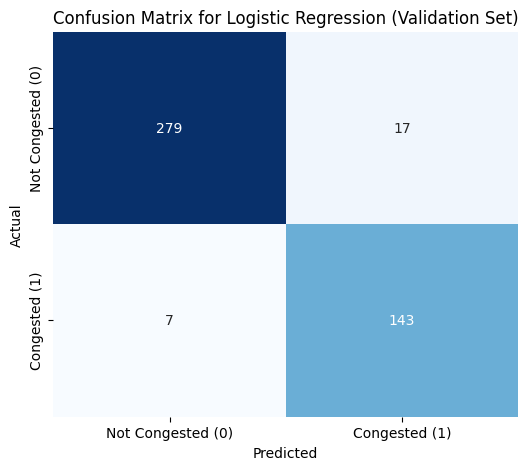

In [23]:
# --- Logistic Regression Model (Standalone Baseline for Comparison) ---
# This model serves as a robust baseline for binary classification.
# It uses built-in optimization (solver) and regularization (C parameter).

print("\n--- Training Logistic Regression Model ---")
print("Optimization: LBFGS/Liblinear Solver")
print("Regularization: L1/L2 (via C parameter)")

# Define parameter grid for GridSearchCV
param_grid = {
    'C': [0.1, 1.0, 10.0], # Regularization strength
    'solver': ['liblinear', 'lbfgs'] # Algorithms, liblinear good for smaller datasets
}

# Initialize Logistic Regression model with class_weight='balanced' for potential imbalance
log_reg = LogisticRegression(random_state=42, class_weight='balanced', max_iter=200)

# Initialize GridSearchCV for hyperparameter tuning
grid_search_log_reg = GridSearchCV(log_reg, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=0)

# Train the model on the training data
grid_search_log_reg.fit(X_train_scaled_df, y_train)

# Get the best model found by GridSearchCV
best_log_reg_model = grid_search_log_reg.best_estimator_

print("\nLogistic Regression training complete.")
print(f"Best Logistic Regression Parameters: {grid_search_log_reg.best_params_}")

# Evaluate the best Logistic Regression model on the Validation Set
y_pred_log_reg_val = best_log_reg_model.predict(X_val_scaled_df)
y_proba_log_reg_val = best_log_reg_model.predict_proba(X_val_scaled_df)[:, 1]

print("\n--- Logistic Regression Validation Metrics ---")
print(f"Validation Accuracy: {accuracy_score(y_val, y_pred_log_reg_val):.4f}")
print(f"Validation Precision: {precision_score(y_val, y_pred_log_reg_val, zero_division=0):.4f}")
print(f"Validation Recall: {recall_score(y_val, y_pred_log_reg_val, zero_division=0):.4f}")
print(f"Validation F1-Score: {f1_score(y_val, y_pred_log_reg_val, zero_division=0):.4f}")

try:
    print(f"Validation ROC AUC: {roc_auc_score(y_val, y_proba_log_reg_val):.4f}")
except ValueError:
    print("Validation ROC AUC: N/A (Cannot compute due to single class in y_val or y_proba_log_reg_val)")

# Add Confusion Matrix and Classification Report for Logistic Regression on Validation Set
print("\n--- Error Analysis for Logistic Regression (Validation Set) ---")
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_pred_log_reg_val, zero_division=0))

plt.figure(figsize=(6, 5))
cm_lr = confusion_matrix(y_val, y_pred_log_reg_val)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Congested (0)', 'Congested (1)'],
            yticklabels=['Not Congested (0)', 'Congested (1)'])
plt.title('Confusion Matrix for Logistic Regression (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


--- Training Neural Network Model 2: Baseline (Adam, No Regularization) ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model architecture diagram saved to 'model_2_architecture.png'

--- Training NN_Model_2_Baseline_Adam ---
NN_Model_2_Baseline_Adam training complete.
  Validation Loss: 0.0993
  Validation Accuracy: 0.9596
  Validation Precision: 0.9177
  Validation Recall: 0.9667
  Validation F1-Score: 0.9416
  Validation AUC: 0.9943


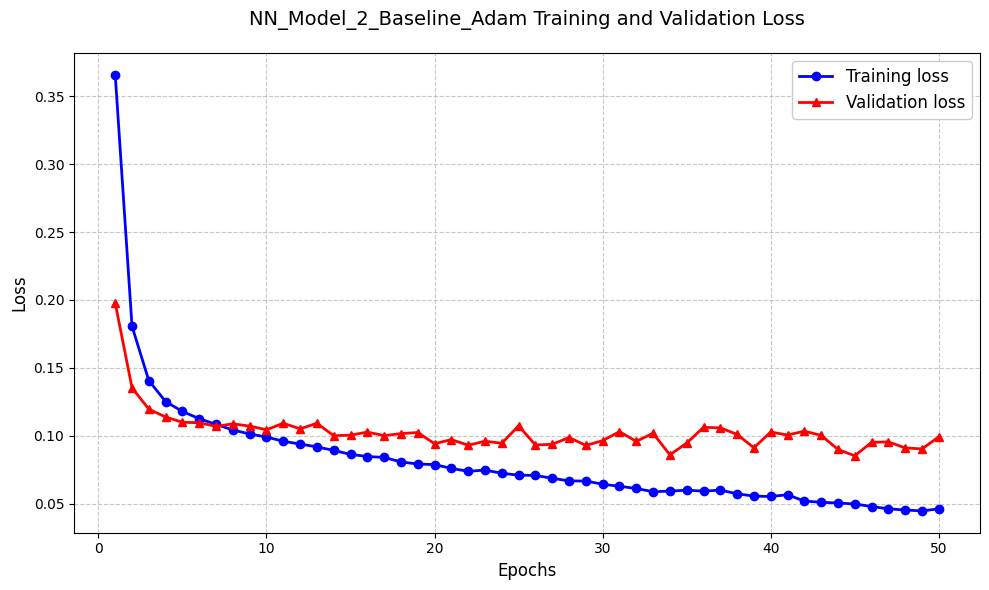


--- Error Analysis for NN_Model_2_Baseline_Adam (Validation Set) ---

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       296
           1       0.92      0.97      0.94       150

    accuracy                           0.96       446
   macro avg       0.95      0.96      0.96       446
weighted avg       0.96      0.96      0.96       446



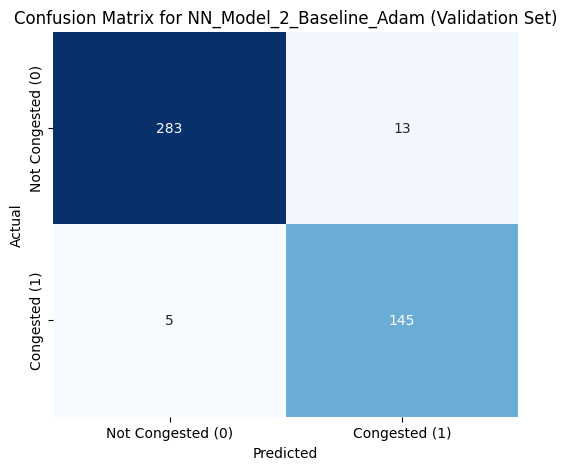

In [24]:
# TODO:
# NN Combination 1 (model_2): Baseline Neural Network
# Optimization: Adam (Default Learning Rate)
# Regularization: None explicitly (simple architecture)

print("\n--- Training Neural Network Model 2: Baseline (Adam, No Regularization) ---")

model_2 = define_model(
    input_dim=input_dim_for_nn,
    optimizer_type='adam',
    learning_rate=0.001,
    dropout_rate=0.0,
    regularization_type=None,
    num_hidden_layers=2, # Simple architecture for baseline
    neurons_per_layer=[64, 32],
    model_name="NN_Model_2_Baseline_Adam"
)

# --- Generate and save model diagram (for SECTION 1 Markdown) ---
try:
    tf.keras.utils.plot_model(
        model_2,
        to_file='model_2_architecture.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB' # 'TB' for top-to-bottom, 'LR' for left-to-right
    )
    print("Model architecture diagram saved to 'model_2_architecture.png'")
except ImportError:
    print("Warning: pydot and graphviz are required to plot model architecture. Run 'pip install pydot graphviz'.")
except Exception as e:
    print(f"Could not plot model architecture: {e}")
# --- END Diagram Generation ---

model_2, history_2 = train_and_evaluate_nn(
    model_2, X_train_scaled_df, y_train, X_val_scaled_df, y_val,
    epochs=50, # Fixed epochs for baseline
    model_name="NN_Model_2_Baseline_Adam"
)

loss_curve_plot(history_2, model_name="NN_Model_2_Baseline_Adam")

# print out confusion matrix and error analysis metrics after the cell
print("\n--- Error Analysis for NN_Model_2_Baseline_Adam (Validation Set) ---")
y_pred_val_proba_m2 = model_2.predict(X_val_scaled_df, verbose=0)
y_pred_val_m2 = (y_pred_val_proba_m2 > 0.5).astype(int)

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_pred_val_m2, zero_division=0))

plt.figure(figsize=(6, 5))
cm_m2 = confusion_matrix(y_val, y_pred_val_m2)
sns.heatmap(cm_m2, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Congested (0)', 'Congested (1)'],
            yticklabels=['Not Congested (0)', 'Congested (1)'])
plt.title('Confusion Matrix for NN_Model_2_Baseline_Adam (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


--- Training Neural Network Model 3: Adam, Dropout, Early Stopping ---

--- Training NN_Model_3_Adam_Dropout_ES ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN_Model_3_Adam_Dropout_ES training complete.
  Validation Loss: 0.0899
  Validation Accuracy: 0.9686
  Validation Precision: 0.9474
  Validation Recall: 0.9600
  Validation F1-Score: 0.9536
  Validation AUC: 0.9946


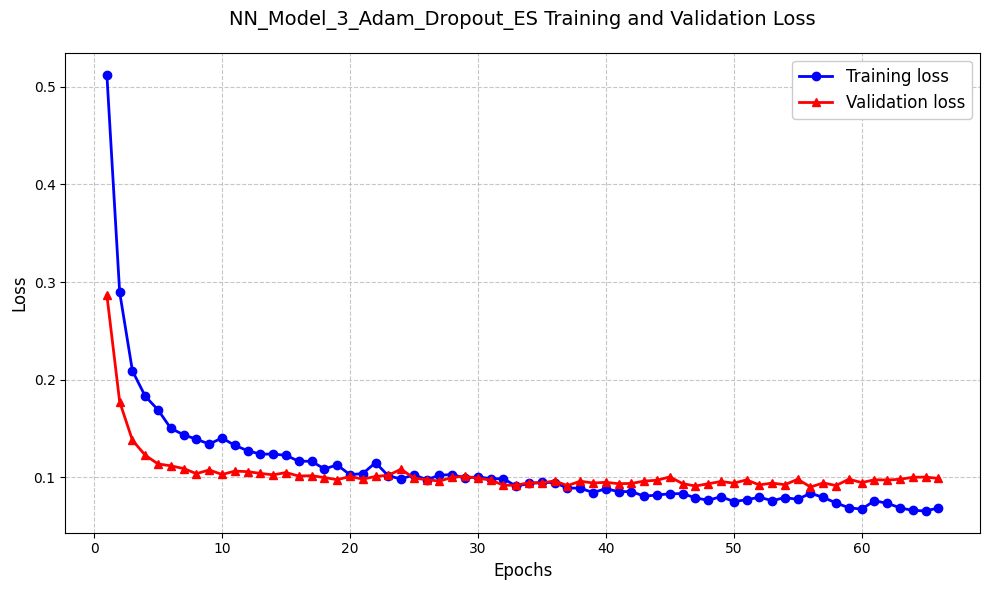


--- Error Analysis for NN_Model_3_Adam_Dropout_ES (Validation Set) ---

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       296
           1       0.95      0.96      0.95       150

    accuracy                           0.97       446
   macro avg       0.96      0.97      0.96       446
weighted avg       0.97      0.97      0.97       446



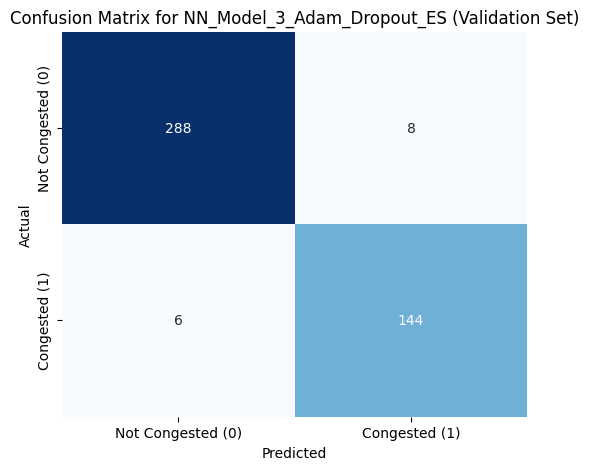

In [25]:
# TODO:
# NN Combination 2 (model_3): Optimized Neural Network
# Optimization: Adam (Custom Learning Rate)
# Regularization: Dropout
# Convergence Speed: Early Stopping

print("\n--- Training Neural Network Model 3: Adam, Dropout, Early Stopping ---")

# Define Early Stopping callback
early_stopping_nn3 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_3 = define_model(
    input_dim=input_dim_for_nn,
    optimizer_type='adam',
    learning_rate=0.0005,
    dropout_rate=0.3,
    regularization_type='dropout',
    num_hidden_layers=3,
    neurons_per_layer=[128, 64, 32],
    model_name="NN_Model_3_Adam_Dropout_ES"
)

model_3, history_3 = train_and_evaluate_nn(
    model_3, X_train_scaled_df, y_train, X_val_scaled_df, y_val,
    epochs=150, # Set higher max epochs, Early Stopping will determine actual epochs
    callbacks=[early_stopping_nn3],
    model_name="NN_Model_3_Adam_Dropout_ES"
)

loss_curve_plot(history_3, model_name="NN_Model_3_Adam_Dropout_ES")

# print out confusion matrix and error analysis metrics after the cell
print("\n--- Error Analysis for NN_Model_3_Adam_Dropout_ES (Validation Set) ---")
y_pred_val_proba_m3 = model_3.predict(X_val_scaled_df, verbose=0)
y_pred_val_m3 = (y_pred_val_proba_m3 > 0.5).astype(int)

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_pred_val_m3, zero_division=0))

plt.figure(figsize=(6, 5))
cm_m3 = confusion_matrix(y_val, y_pred_val_m3)
sns.heatmap(cm_m3, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Congested (0)', 'Congested (1)'],
            yticklabels=['Not Congested (0)', 'Congested (1)'])
plt.title('Confusion Matrix for NN_Model_3_Adam_Dropout_ES (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


--- Training Neural Network Model 4: RMSprop, L2 Regularization ---

--- Training NN_Model_4_RMSprop_L2 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NN_Model_4_RMSprop_L2 training complete.
  Validation Loss: 0.1157
  Validation Accuracy: 0.9596
  Validation Precision: 0.9177
  Validation Recall: 0.9667
  Validation F1-Score: 0.9416
  Validation AUC: 0.9949


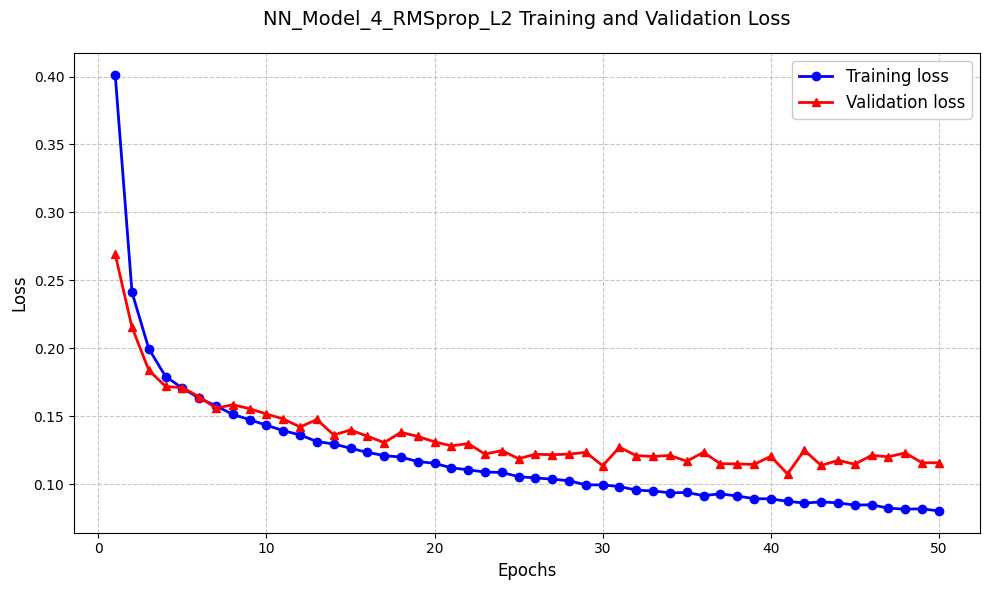


--- Error Analysis for NN_Model_4_RMSprop_L2 (Validation Set) ---

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       296
           1       0.92      0.97      0.94       150

    accuracy                           0.96       446
   macro avg       0.95      0.96      0.96       446
weighted avg       0.96      0.96      0.96       446



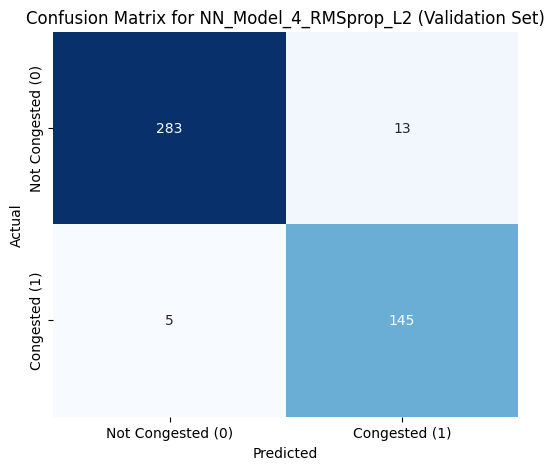

In [26]:
# TODO:
# NN Combination 3 (model_4): Optimized Neural Network
# Optimization: RMSprop
# Regularization: L2 Regularization

print("\n--- Training Neural Network Model 4: RMSprop, L2 Regularization ---")

model_4 = define_model(
    input_dim=input_dim_for_nn,
    optimizer_type='rmsprop',
    learning_rate=0.001,
    dropout_rate=0.0,
    regularization_type='l2',
    regularization_strength=0.001,
    num_hidden_layers=2,
    neurons_per_layer=[64, 32],
    model_name="NN_Model_4_RMSprop_L2"
)

model_4, history_4 = train_and_evaluate_nn(
    model_4, X_train_scaled_df, y_train, X_val_scaled_df, y_val,
    epochs=50,
    model_name="NN_Model_4_RMSprop_L2"
)

loss_curve_plot(history_4, model_name="NN_Model_4_RMSprop_L2")

# print out confusion matrix and error analysis metrics after the cell
print("\n--- Error Analysis for NN_Model_4_RMSprop_L2 (Validation Set) ---")
y_pred_val_proba_m4 = model_4.predict(X_val_scaled_df, verbose=0)
y_pred_val_m4 = (y_pred_val_proba_m4 > 0.5).astype(int)

print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_pred_val_m4, zero_division=0))

plt.figure(figsize=(6, 5))
cm_m4 = confusion_matrix(y_val, y_pred_val_m4)
sns.heatmap(cm_m4, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Congested (0)', 'Congested (1)'],
            yticklabels=['Not Congested (0)', 'Congested (1)'])
plt.title('Confusion Matrix for NN_Model_4_RMSprop_L2 (Validation Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [27]:
# Task: Make Predictions using the best saved model

def make_predictions(model_path, X):
    """
    Loads a saved Keras model and makes predictions.

    Args:
        model_path (str): Path to the saved .h5 Keras model file.
        X (pd.DataFrame or np.array): Features to make predictions on.

    Returns:
        np.array: Binary predictions (0 or 1).
        np.array: Probability predictions.
    """
    # Load the model
    model = load_model(model_path)
    print(f"Model loaded from: {model_path}")

    # Make predictions (probabilities)
    predictions_proba = model.predict(X, verbose=0)
    # Convert probabilities to binary labels (0 or 1)
    predictions_binary = (predictions_proba > 0.5).astype(int)

    return predictions_binary, predictions_proba

# Modify the code appropriately (This is just the function definition)


Best model 'NN_Model_3_Adam_Dropout_ES' saved to 'NN_Model_3_Adam_Dropout_ES_best_model.h5'

--- Making Predictions on Test Set using the Best Model ---
Model loaded from: NN_Model_3_Adam_Dropout_ES_best_model.h5

--- Error Analysis on Test Data ---
Model Used for Test Evaluation: NN_Model_3_Adam_Dropout_ES

Test Accuracy: 0.9731543624161074
Test Precision: 0.9602649006622517
Test Recall: 0.9602649006622517
Test F1-Score: 0.9602649006622517
Test ROC AUC: 0.990849293001611

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       296
           1       0.96      0.96      0.96       151

    accuracy                           0.97       447
   macro avg       0.97      0.97      0.97       447
weighted avg       0.97      0.97      0.97       447



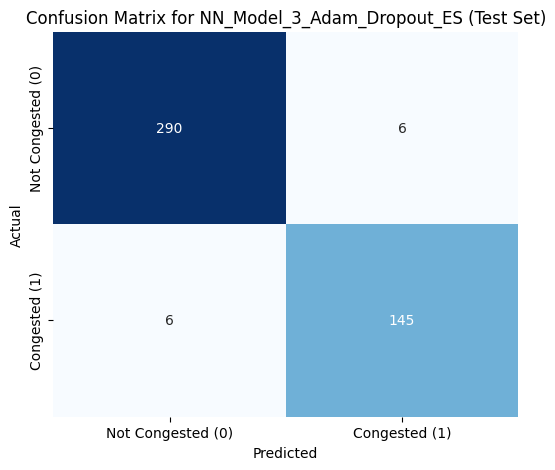

In [28]:
# Finally, Make predictions using the best model. By the time you get to this cell you may realise
# at some point you needed to save the model so that you cal load it later

# --- Select the best model for final evaluation ---
# Based on the validation metrics printed above (from Logistic Regression, model_2, model_3, model_4),
# choose which model performed best overall.
# For demonstration, let's assume 'model_3' (Adam, Dropout, ES) was the best NN.
# You might change this to 'best_log_reg_model' or 'model_2' or 'model_4'
# based on your actual validation results.

best_overall_model_name = "NN_Model_3_Adam_Dropout_ES" # Change this if a different model is better
best_overall_model_object = model_3 # Assign the actual model object (e.g., model_2, model_3, model_4, or best_log_reg_model)

# --- Save the best model ---
model_path_to_save = f"{best_overall_model_name}_best_model.h5"
best_overall_model_object.save(model_path_to_save)
print(f"\nBest model '{best_overall_model_name}' saved to '{model_path_to_save}'")

# Use the make_predictions function (which loads the model from path)
print("\n--- Making Predictions on Test Set using the Best Model ---")
final_model_binary_preds, final_model_proba_preds = make_predictions(model_path_to_save, X_test_scaled_df)

# --- Error Analysis Techniques ---
# Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible
print("\n--- Error Analysis on Test Data ---")
print(f"Model Used for Test Evaluation: {best_overall_model_name}")

# Print out confusion matrix and error analysis metrics after the cell
print("\nTest Accuracy:", accuracy_score(y_test, final_model_binary_preds))
print("Test Precision:", precision_score(y_test, final_model_binary_preds, zero_division=0))
print("Test Recall:", recall_score(y_test, final_model_binary_preds, zero_division=0))
print("Test F1-Score:", f1_score(y_test, final_model_binary_preds, zero_division=0))

try:
    print("Test ROC AUC:", roc_auc_score(y_test, final_model_proba_preds))
except ValueError:
    print("Test ROC AUC: N/A (Cannot compute due to single class in y_test or predictions)")

print("\nClassification Report (Test Set):")
print(classification_report(y_test, final_model_binary_preds))

# Plot Confusion Matrix using plotting libraries (not verbose)
plt.figure(figsize=(6, 5))
cm_final = confusion_matrix(y_test, final_model_binary_preds)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Congested (0)', 'Congested (1)'],
            yticklabels=['Not Congested (0)', 'Congested (1)'])
plt.title(f'Confusion Matrix for {best_overall_model_name} (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Congratulations!!
